Resynthesis

Boundary addition on splitting

K-fold cross validation

Add mridangam and ghatam

Keep in mind: Dual pitch tracking

In [1]:
import numpy as np
import pandas as pd
import copy
import os
import sys
import random
import matplotlib.pyplot as plt
import librosa.display
import json
import time

import torch
import torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Resample, Fade
from torchaudio.functional import pitch_shift
from IPython.display import Audio
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from utils import *

sys.path.append('/Users/venkatakrishnanvk/Desktop/Music Technology/Audio Processing/sms-tools-1/software/models/')
import utilFunctions as UF
import dftModel as DFT
import stft
import harmonicModel as HM
import sineModel as SM

sys.path.append('/Users/venkatakrishnanvk/Desktop/Music Technology/Preeti Ma\'am/Polyphonic Melody Detection/FTANet-melodic/')
import cfp
import generator as gn
from network.ftanet_pytorch import FTAnet
from evaluator import est                   # For estimating frequency from the indices
from evaluator import iseg, melody_eval

# sys.path.append('/Users/venkatakrishnanvk/Desktop/Music Technology/carnatic-pitch-patterns/carnatic-melody-synthesis/')
from pitch_track_processing_violin import PitchProcessor

In [2]:
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)

In [3]:
ftanet:nn.Module = FTAnet()
ftanet.load_state_dict(torch.load('ftanet_temp.pth'))
ftanet = ftanet.to('cpu')
torch.save(ftanet.state_dict(), 'ftanet_temp2.pth')

# Dataset
TODO:
- Same singer

In [4]:
# loc = '../../Datasets/Carnatic Violin Dataset/'
# names = []
# ext = ".wav"
# for (path, dirs, files) in os.walk(loc):
#     for f in files:
#         if ext.split('.')[-1].lower() == f.split('.')[-1].lower():
#             names.append(path + "/" + f)

`names` is the list of paths to all wav files

In [5]:
# violin = [torchaudio.load(i)[0][0] for i in names]
# print(violin[0].shape)
# torch.save(violin, './carnatic_violin_dataset.pt')

In [6]:
# violin = torch.load('./carnatic_violin_dataset.pt')
# violin[0].shape

### Max violin pitch

In [7]:
root = '../../Datasets/carnatic/violin_solo_dataset/'
pitch_tracks_type1 = [torch.tensor(np.loadtxt(root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v2.csv', delimiter=',')) for i in range(13, 784)]
pitch_tracks_type2 = [torch.tensor(np.loadtxt(root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v2.csv', delimiter=',')) for i in range(13)]

In [8]:
max_value = 0
for pitches in pitch_tracks_type1:
    value = torch.max(pitches.T[1]).item()
    if max_value < value:
        max_value = value
print("Type I max frequency:",max_value)

Type I max frequency: 1195.2135009765625


In [9]:
max_value = 0
for pitches in pitch_tracks_type2:
    value = torch.max(pitches.T[1]).item()
    if max_value < value:
        max_value = value
print("Type II max frequency:",max_value)

Type II max frequency: 1216.1055908203125


Will require approximately 28 GB of free space

In [10]:
torch.tensor([0,0,0,0,0,0,0,0]).isnan().sum()

tensor(0)

Change the pitch_tracks to 4096 frame size

In [11]:
tanpura = '../../carnatic-pitch-patterns/carnatic-melody-synthesis/resources/tanpura_tracks'
hello = pitch_shift(torchaudio.load(tanpura+'/tanpura_Angarai_V_K_Rajasimhan.wav')[0][0], 44100, -3, win_length=4096, n_fft = 4096, hop_length=441)
W, _, _ = cfp.cfp_process(y = hello, sr = 44100, hop = 441, win=4096)
print(W.shape)

(3, 320, 3049)


Saraga complain about metadata

In [13]:
class ViolinMixtureDataset(Dataset):
    def __init__(self, root = '../../Datasets/carnatic/violin_solo_dataset/', time_segment = 128, snr: list = [-5, -4, -3.125, -2.5, -1.75, -1, 0, 2.5], train = True) -> None:
        super(ViolinMixtureDataset, self).__init__()
        self.train = train
        self.sr = 44100
        self.snr = snr
        self.hop = 441 # 10 ms
        self.win_size = 4096 # changed
        self.root = root
        # resample = Resample(44100, 8000)
        violin_file = [root+'violin_solo'+str(i)+'.wav' for i in range(13)]
        # self.violin = [resample(torchaudio.load(i)[0][0]) for i in violin_file]
        self.violin = [torchaudio.load(i, normalize = True)[0][0] for i in violin_file]
        self.violin.extend(torch.load('./carnatic_violin_dataset.pt'))
        self.orig_len = len(self.violin)

        loc = root+'vocal/vocalists/'
        # self.vocal = [resample(torchaudio.load(loc+'vocal'+str(i+1)+'.wav')[0][0]) if i > 8 else resample(torchaudio.load(loc+'vocal'+'0'+str(i+1)+'.wav')[0][0]) for i in range(len(os.listdir(loc)))]
        self.vocal = [torchaudio.load(loc+'vocal'+str(i+1)+'.wav', normalize = True)[0][0] if i > 8 else torchaudio.load(loc+'vocal'+'0'+str(i+1)+'.wav', normalize = True)[0][0] for i in range(len(os.listdir(loc)))]
        self.pitch_proc = PitchProcessor(voicing = True)
        self.fade = Fade(16, 16)
        self.data = []
        count = 0
        try:
            count = 0
            self.pitch_tracks = [torch.load(self.root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v3.pt') for i in range(self.orig_len)]
            # self.pitch_tracks = [torch.tensor(np.loadtxt(root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v2.csv', delimiter=',')) for i in range(len(self.violin))]
        except:
            count = 1
            self.pitch_tracks = [torch.tensor(np.loadtxt(root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v2.csv', delimiter=',')) for i in range(self.orig_len)]

        if self.train and count == 1:
            mixture_loc = self._create_mixtures() # Write the mixtures
            self._generate_CFP_features(mixture_loc)

        with open("mixtures/cen_freq", "r") as fp:
            self.Cen_freq = json.load(fp)
        
        # Split cfp to chunks
        self.cfp_data = [[] for _ in self.snr] # CHECK!

        self.time = torch.linspace(self.hop/self.sr, self.hop/self.sr*time_segment, time_segment)
        self._extract_CFP(num_examples = len(self.violin))

        temp_pitch_tracks = copy.deepcopy(self.pitch_tracks)

        for i in range(len(self.snr)):
            self.cfp_data[i], self.pitch_tracks = self._split_to_chunks(self.cfp_data[i], temp_pitch_tracks, time_segment)
        self._create_data(self.cfp_data, self.pitch_tracks)
    
    def _create_mixtures(self, gap = 0.5): # As of now it is random singers, change later
        # mixture = []
        mixture_loc = []
        new_pitch_tracks = []
        new_violin_piece = torch.Tensor([])
        time_gap = int(gap*self.sr) # 0.5 second
        for i, (violin_piece, pitch_track) in enumerate(zip(self.violin, self.pitch_tracks)):
            # violin_piece:torch.Tensor = violin_piece/torch.max(violin_piece)
            if not os.path.exists(self.root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v3.pt'):
                new_violin_piece, processed_pitch, processed_time_stamps = self.pitch_proc.pre_processing(violin_piece.numpy(), pitch_track.numpy())
                processed_pitch = PitchProcessor.fix_octave_errors(processed_pitch)
                # wavfile.write('trial'+str(i)+'.wav', rate = self.sr, data = new_violin_piece/np.max(new_violin_piece))
                new_pitch_tracks.append(torch.cat([torch.Tensor(processed_time_stamps).view(-1, 1), torch.Tensor(processed_pitch).view(-1, 1)], 1))
                torch.save(new_pitch_tracks[i], self.root+'pitch_tracks/violin_solo'+str(i)+'_melodia_v3.pt')
                
                new_violin_piece2 = torch.Tensor(new_violin_piece/np.max(new_violin_piece))
                new_violin_piece = torch.nan_to_num(new_violin_piece2, nan=0.0)
                print(pitch_track.shape)

            for snr_value in self.snr:
                if not os.path.isfile('mixtures/mixture'+str(i)+'_snr'+str(snr_value)+'.wav'):
                    time_point = 0
                    temp_violin_piece = copy.deepcopy(new_violin_piece)
                    while time_point<len(new_violin_piece):
                        vocal_piece = random.sample(self.vocal, k = 1)[0] # Sampling a random vocal snippet
                        while len(vocal_piece) == 0:
                            vocal_piece = random.sample(self.vocal, k = 1)[0]
                        time_point2 = time_point + len(vocal_piece) + time_gap
                        vocal_piece = vocal_piece/torch.max(vocal_piece)  # Normalisation
                        vocal_piece = torch.nan_to_num(vocal_piece, nan=0.0)
                        vocal_piece = self.fade(vocal_piece)
                        if len(temp_violin_piece[time_point:time_point2]) - len(vocal_piece) >= 0:
                            padded_vocal_piece = torch.nn.functional.pad(vocal_piece, (0, len(temp_violin_piece[time_point:time_point2]) - len(vocal_piece)))
                        else:
                            # padded_vocal_piece = vocal_piece[:len(temp_violin_piece[time_point:])] * np.linspace(1.0,0.0,len(temp_violin_piece[time_point:]))
                            padded_vocal_piece = vocal_piece[:len(temp_violin_piece[time_point:time_point2])]
                        # temp_violin_piece[time_point:] = temp_violin_piece[time_point:]+padded_vocal_piece
                        temp_violin_piece[time_point:time_point2] = self.get_mix(snr_value, temp_violin_piece[time_point:time_point2], padded_vocal_piece)
                        time_point = time_point2
                    # mixture.append(temp_violin_piece)
                    # wavfile.write('mixtures/mixture'+str(i)+'.wav', rate = self.sr, data = temp_violin_piece.numpy())
                    temp_violin_piece = temp_violin_piece/torch.max(temp_violin_piece)
                    temp_violin_piece = torch.nan_to_num(temp_violin_piece, nan=0.0)
                    wavfile.write('mixtures/mixture'+str(i)+'_snr'+str(snr_value)+'.wav', rate = self.sr, data = temp_violin_piece.numpy())
                    # # torch.save(temp_violin_piece, 'mixtures/mixture'+str(i)+'.pt')

                mixture_loc.append('mixtures/mixture'+str(i)+'_snr'+str(snr_value)+'.wav') 
        # if not existence:
        #     self.pitch_tracks = new_pitch_tracks
        del new_pitch_tracks     
        return mixture_loc
    
    def _generate_CFP_features(self, mixture_loc):
        # cfp_data = [[] for _ in self.snr]
        for i, loc in enumerate(mixture_loc):
            if not os.path.isfile('mixtures/mixture_CFP'+str(i//len(self.snr))+'_snr'+str(self.snr[i%len(self.snr)])+'.pt'):
                W, Cen_freq, _ = cfp.cfp_process(loc, sr = self.sr, hop = self.hop, win=self.win_size)
                # W_norm = W
                W_norm = gn.std_normalize(W)
                # Shape: (3, freq_bin, time_frames)
                # cfp_data[i%len(self.snr)].append(torch.Tensor(W_norm))

                torch.save(torch.Tensor(W_norm), 'mixtures/mixture_CFP'+str(i//len(self.snr))+'_snr'+str(self.snr[i%len(self.snr)])+'.pt')
        
                with open("mixtures/cen_freq", "w") as fp:
                    json.dump(Cen_freq, fp)
    
    def _extract_CFP(self, num_examples):
        for j in ['mixtures/mixture_CFP'+str(i)+'_snr' for i in range(num_examples)]:
            for idx, k in enumerate(self.snr):
                self.cfp_data[idx].append(torch.load(j+str(k)+'.pt'))
    
    def _split_to_chunks(self, data, pitch_tracks, time_segment = 128, hop_len = 32):
        iterate_num = 0
        temp_mixtures = []
        new_pitch_tracks = []
        for cfp_mixture, pitch_track in zip(data, pitch_tracks):
            mixture1 = cfp_mixture # Shape: (3, freq_bin, time_frames)
            pitch_track1:torch.Tensor = pitch_track.T[1]
            # if not pitch_track1.any().item(): # Check if all values in the array are zeros
            #     continue
            temp_pitch_track = torch.zeros_like(pitch_track1, dtype=torch.int64)
            for i, pitch_value in enumerate(pitch_track1):
                ind = cfp.freq2ind(
                    pitch_value.numpy(),
                    StartFreq = 31,
                    StopFreq = 1250,
                    NumPerOct = 60
                )
                if ind == None:
                    ind = 0
                temp_pitch_track[i] = int(ind)
            pitch_track1 = temp_pitch_track
            while True:
                # Ignoring all pure vocals which are not part of tanpura mixtures
                if iterate_num < self.orig_len and not pitch_track1[:time_segment].any().item() and mixture1.shape[-1]>=time_segment:
                    mixture1 = mixture1[:,:,time_segment-hop_len:]
                    pitch_track1 = pitch_track1[time_segment-hop_len:]
                    continue
                if mixture1.shape[-1]>=time_segment: # Check if longer than 30s
                    temp_mixtures.append(mixture1[:,:,:time_segment])
                    new_pitch_tracks.append(pitch_track1[:time_segment])
                else:
                    mixture1 = self._right_pad_if_necessary(mixture1, length_req=time_segment)
                    temp_mixtures.append(mixture1)
                    new_pitch_tracks.append(self._right_pad_if_necessary(pitch_track1, length_req=time_segment))
                    break
                mixture1 = mixture1[:,:,time_segment-hop_len:]
                pitch_track1 = pitch_track1[time_segment-hop_len:]
            iterate_num+=1
        return temp_mixtures, new_pitch_tracks

    def _right_pad_if_necessary(self, CFP, length_req):
        # waveform.shape --> Tensor --> (no. of samples)
        length_signal = CFP.shape[-1]
        if(length_signal < length_req):
            num_missing_samples = length_req - length_signal
            last_dimension_padding = (0, num_missing_samples)
            CFP = torch.nn.functional.pad(CFP, last_dimension_padding)
        else:
            CFP = CFP[:length_req]
        assert CFP.shape[-1]==length_req
        return CFP

    def _create_data(self, cfp, pitch_tracks):
        # Ensures all same snr will go to train and not to test and vice versa
        for cfps in cfp:
            X_train, X_test, y_train, y_test = train_test_split(cfps, pitch_tracks, test_size=0.1, random_state=seed)
            if self.train:
                for i,j in zip(X_train, y_train):
                    # Only nan removed
                    if j.isnan().sum() == 0 and i.isnan().sum() == 0:
                        self.data.append((i,j))
            else:
                for i,j in zip(X_test, y_test):
                    # Only nan removed
                    if j.isnan().sum() == 0 and i.isnan().sum() == 0:
                        self.data.append((i,j))
        random.shuffle(self.data)
        del self.cfp_data
        del cfp
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    @staticmethod
    def get_mix(SNR_level, x_voc, x_har):
        x_har = x_har/torch.max(x_har)
        x_voc = x_voc/torch.max(x_voc)

        x_har = torch.nan_to_num(x_har, nan=0.0)
        x_voc = torch.nan_to_num(x_voc, nan=0.0)
        
        power1 = torch.mean(x_har**2)
        power2 = torch.mean(x_voc**2)
        snr1 = 10*torch.log10(power1)
        snr2 = 10*torch.log10(power2)

        if snr1.item() > -45 and snr2.item() > -45:
            ratio = (SNR_level+snr2)/snr1
            power1__ = 10**((ratio*snr1)/10)
            alpha = torch.sqrt(power1__/power2)
            sig1 = x_voc*alpha

            power1_ = torch.mean(sig1**2)
            
            snr1 = 10*torch.log10(power1_)
            snr2 = 10*torch.log10(power2)
            # delta_snr = snr1 - snr2
        else:
            print(snr2)
            alpha = 1

        x_mix = x_voc*alpha+x_har
        x_mix = x_mix/torch.max(x_mix)
        x_mix = torch.nan_to_num(x_mix, nan=0.0)
        
        return x_mix

Fix octave errors also in the dataset itself

In [14]:
train_data = ViolinMixtureDataset(train=True)
test_data = ViolinMixtureDataset(train=False)
# torch.save(train_data, 'mixtures/train_data4.pt')
# torch.save(test_data, 'mixtures/test_data4.pt')

In [14]:
train_data = torch.load('mixtures/train_data4.pt')
test_data = torch.load('mixtures/test_data4.pt')

In [17]:
len(train_data), len(test_data)

(64365, 7159)

In [16]:
torch.save(train_data, 'mixtures/train_data4.pt')
torch.save(test_data, 'mixtures/test_data4.pt')

In [15]:
len(train_data), len(test_data)

(66789, 7423)

In [16]:
num = 10

In [17]:
train_data[num][0].shape, train_data[num][1].shape, test_data[num][0].shape, test_data[num][1].shape

(torch.Size([3, 320, 128]),
 torch.Size([128]),
 torch.Size([3, 320, 128]),
 torch.Size([128]))

In [18]:
train_data[num][1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Text(0.5, 1.0, 'Cepstrum of Spectrum Spectrogram')

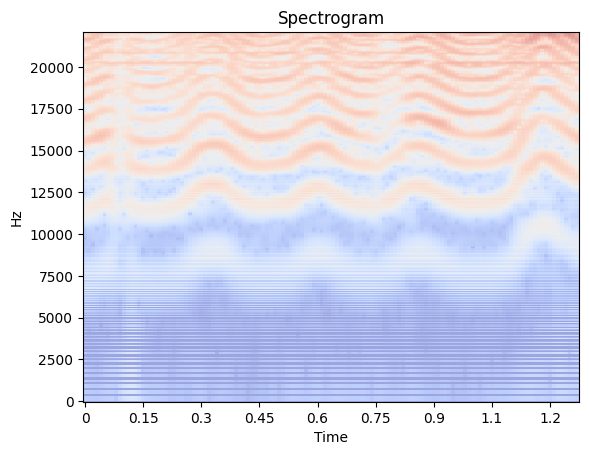

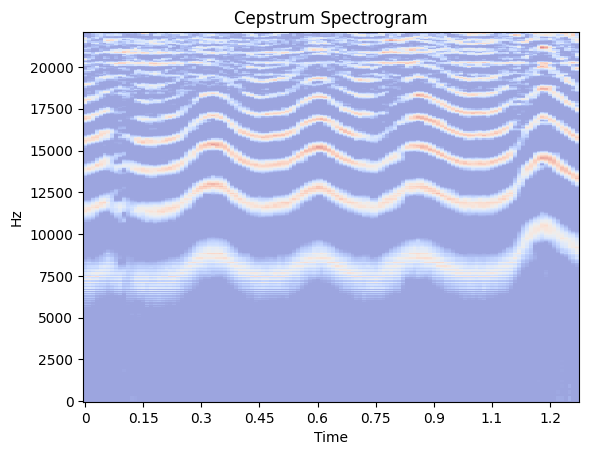

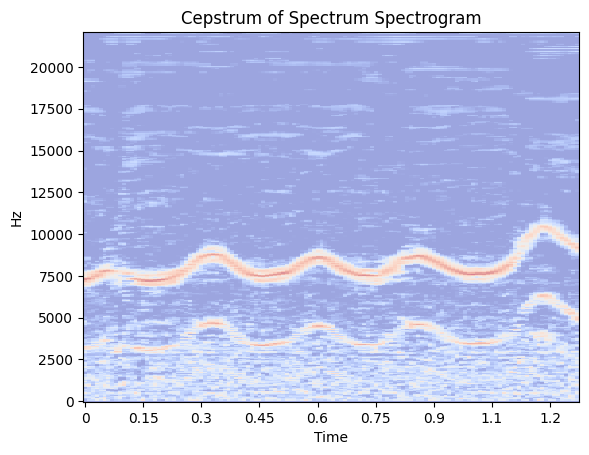

In [19]:
plt.figure(1)
librosa.display.specshow(train_data[num][0][0].numpy(), sr = 44100, alpha = 0.5, x_axis='time', y_axis='linear', hop_length = 441)
plt.title('Spectrogram')
plt.figure(2)
librosa.display.specshow(train_data[num][0][1].numpy(), sr = 44100, alpha = 0.5, x_axis='time', y_axis='linear', hop_length = 441)
plt.title('Cepstrum Spectrogram')
plt.figure(3)
librosa.display.specshow(train_data[num][0][2].numpy(), sr = 44100, alpha = 0.5, x_axis='time', y_axis='linear', hop_length = 441)
plt.title('Cepstrum of Spectrum Spectrogram')

In [20]:
nn.functional.one_hot(train_data[num][1], num_classes=train_data[num][0].shape[-2]).T.shape

torch.Size([320, 128])

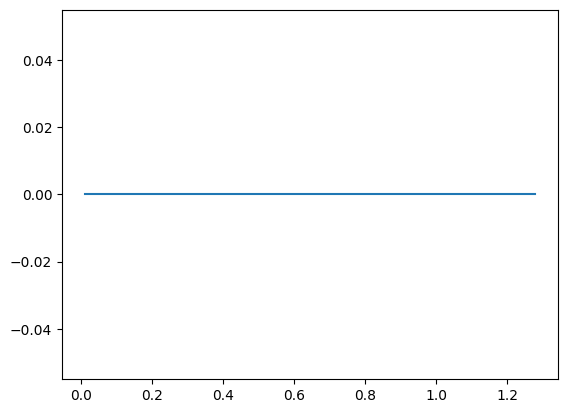

In [21]:
example = nn.functional.one_hot(train_data[num][1], num_classes=train_data[num][0].shape[-2]).T

x, y = est(example, train_data.Cen_freq, train_data.time).T
plt.plot(x, y)

### Hyperparameters

In [35]:
batch_size = 32
learning_rate = 0.0008

In [36]:
train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False
)

In [37]:
CFP, pitch_track = next(iter(train_loader))
CFP.shape, pitch_track.shape

(torch.Size([32, 3, 320, 128]), torch.Size([32, 128]))

### Load model

In [38]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='mps')

In [39]:
ftanet = FTAnet().to(device)

### Loss and Optimizer

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ftanet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [41]:
def evaluate(ftanet, loader, batch_size):
    avg_eval_arr = np.array([0, 0, 0, 0, 0], dtype='float64')
    for i, (x, y) in enumerate(loader):
        num = x.shape[0] // batch_size
        if x.shape[0] % batch_size != 0:
            num += 1
        preds = []

        for j in range(num):
            # x: (batch_size, 3, freq_bins, seg_len)
            if j == num - 1:
                X = x[j*batch_size:, :, :, :]
                length = x.shape[0]-j*batch_size
            else:
                X = x[j*batch_size : (j+1)*batch_size, :, :, :]
                length = batch_size
        
            # for k in range(length): # normalization
            #     X[k, :, :, :] = torch.Tensor(gn.std_normalize(X[k, :, :, :].numpy()))

            with torch.no_grad():
                prediction = ftanet(X)[0]
                for pred_batch in prediction:
                    preds.append(pred_batch[0].numpy())
    
        preds = np.array(preds)
        ## (num*bs, freq_bins, seg_len) to (freq_bins, T)
        # preds = np.concatenate(preds, axis=0)
        preds = iseg(preds)

        actual_arr = []
        for y1 in y:
            actual_arr.append(np.array(nn.functional.one_hot(y1, num_classes=train_data[0][0].shape[-2]+1).T))
        actual_arr = np.array(actual_arr)
        actual_arr = iseg(actual_arr)

        CenFreq = train_data.Cen_freq

        time_arr = torch.linspace(train_data.hop/train_data.sr, train_data.hop/train_data.sr*preds.shape[1], preds.shape[1])
        ref_arr = est(actual_arr, CenFreq, time_arr)

        
        # y = torch.stack((time_arr, y.flatten())).T
        # print(y.shape)
        
        # ground-truth
        # ref_arr = y.numpy()
        # time_arr = y.numpy()[:, 0]
        
        # transform to f0ref
        est_arr = est(preds, CenFreq, time_arr)

        # evaluate
        eval_arr = melody_eval(ref_arr, est_arr)
        avg_eval_arr += eval_arr
        if (i+1)%5==0:
            print(avg_eval_arr/(i+1))
    avg_eval_arr /= len(loader)
    # VR, VFA, RPA, RCA, OA
    return avg_eval_arr  

In [42]:
num_epochs = 10
losses = []
time_segment = 128
freq_bins = 320

In [43]:
# ftanet = torch.load('./ftanet_best3.pt')
# optimizer.load_state_dict(torch.load('./ftanet_optimizer_best3.pt'))
# scheduler.load_state_dict(torch.load('./ftanet_scheduler_best3.pt'))

In [44]:
best_weights = copy.deepcopy(ftanet.state_dict())
max = 0
val_acc = 0
train_acc = 0
for epoch in range(num_epochs):
    ftanet.train()
    ftanet.to(device)
    for i, (cfp_data, pitch) in enumerate(train_loader):
        tic = time.time()
        cfp_data = cfp_data.to(device)
        pitch = pitch.to(device)

        preds, preds_pre = ftanet(cfp_data)
        preds = preds.view(-1, freq_bins+1, time_segment)
        loss = criterion(preds, pitch)
        if torch.isnan(loss):
            print(f'Step {i+1}/{len(train_loader)}; Loss = {loss.item():.6f}; Time = {time.time()-tic:.1f} s')
            print("Skipping Step...")
            optimizer.zero_grad()
            loss.backward()
            optimizer.zero_grad()
            weights = torch.load('ftanet_temp.pth')
            ftanet.load_state_dict(weights)
            continue
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{len(train_loader)}; Loss = {loss.item():.6f}; Time = {time.time()-tic:.1f} s')
        torch.save(ftanet.state_dict(), 'ftanet_temp.pth')
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    with torch.no_grad():
        ftanet2 = ftanet.to('cpu')
        ftanet2.eval()
        avg_eval_test = evaluate(ftanet2, test_loader, batch_size)
        if (max <= (avg_eval_test[0]+avg_eval_test[2]+avg_eval_test[3]+avg_eval_test[4])/4):
            print('SAVED MODEL WEIGHTS')
            max = (avg_eval_test[0]+avg_eval_test[2]+avg_eval_test[3]+avg_eval_test[4])/4
            best_weights = copy.deepcopy(ftanet2.state_dict())
            torch.save(ftanet, 'ftanet_4.pt')
            torch.save(ftanet.state_dict(), 'ftanet_4.pth')
            torch.save(optimizer.state_dict(), 'ftanet_optimizer_4.pt')
            torch.save(scheduler.state_dict(), 'ftanet_scheduler_4.pt')
        
        if (epoch+1)%25 == 0:
            avg_eval_train = evaluate(ftanet2, train_loader, batch_size)
            print('TRAIN - ')
            print(f'Voicing Recall: {avg_eval_train[0]:.2f}%')
            print(f'Voicing False Alarm: {avg_eval_train[1]:.2f}%')
            print(f'Raw Pitch Accuracy: {avg_eval_train[2]:.2f}%')
            print(f'Raw Chroma Accuracy: {avg_eval_train[3]:.2f}%')
            print(f'Overall Accuracy: {avg_eval_train[4]:.2f}%\n')
    print('TEST - ')
    print(f'Voicing Recall: {avg_eval_test[0]:.2f}%')
    print(f'Voicing False Alarm: {avg_eval_test[1]:.2f}%')
    print(f'Raw Pitch Accuracy: {avg_eval_test[2]:.2f}%')
    print(f'Raw Chroma Accuracy: {avg_eval_test[3]:.2f}%')
    print(f'Overall Accuracy: {avg_eval_test[4]:.2f}%\n')
    print("-"*20)

Step 1/2088; Loss = 5.769958; Time = 5.4 s
Step 2/2088; Loss = 5.756908; Time = 1.2 s
Step 3/2088; Loss = 5.742344; Time = 1.2 s
Step 4/2088; Loss = 5.717029; Time = 1.2 s
Step 5/2088; Loss = 5.718284; Time = 1.1 s
Step 6/2088; Loss = 5.709982; Time = 1.1 s
Step 7/2088; Loss = 5.685303; Time = 1.1 s
Step 8/2088; Loss = 5.673762; Time = 1.1 s
Step 9/2088; Loss = 5.672904; Time = 1.1 s
Step 10/2088; Loss = 5.638070; Time = 1.2 s
Step 11/2088; Loss = 5.674402; Time = 1.1 s
Step 12/2088; Loss = 5.619085; Time = 1.2 s
Step 13/2088; Loss = 5.595973; Time = 1.2 s
Step 14/2088; Loss = 5.583514; Time = 1.1 s
Step 15/2088; Loss = 5.617843; Time = 1.1 s
Step 16/2088; Loss = 5.644040; Time = 1.1 s
Step 17/2088; Loss = 5.626908; Time = 1.1 s
Step 18/2088; Loss = 5.578448; Time = 1.1 s
Step 19/2088; Loss = 5.621225; Time = 1.1 s
Step 20/2088; Loss = 5.608527; Time = 1.1 s
Step 21/2088; Loss = 5.558518; Time = 1.1 s
Step 22/2088; Loss = 5.550494; Time = 1.1 s
Step 23/2088; Loss = 5.636361; Time = 1.2

KeyboardInterrupt: 

In [46]:
ftanet = ftanet.to('cpu')
torch.save(ftanet.state_dict(), 'ftanet_4.pth')
torch.save(optimizer.state_dict(), 'ftanet_optimizer_4.pt')
torch.save(scheduler.state_dict(), 'ftanet_scheduler_4.pt')

In [21]:
with torch.no_grad():
    ftanet2 = ftanet.to('cpu')
    ftanet2.eval()
    avg_eval_test = evaluate(ftanet2, test_loader, batch_size, train_data)

[95.43763208  2.35889287 86.89062201 87.55082841 88.50866488]
[95.47005045  4.46672226 85.30895244 86.4878112  86.89284843]
[95.82485996  6.42140801 85.81022989 86.77549673 86.9579367 ]
[96.3121879   5.76353836 86.15430346 86.92086608 87.42128387]
[96.5074278   4.88742023 86.34180971 87.15110196 87.74225043]
[96.5129828   5.19099184 85.9680873  86.81816676 87.45667562]
[96.67622199  5.6613676  86.61796758 87.41262349 87.92705464]
[96.44062805  5.55351546 85.92155938 87.00853852 87.34012692]
[96.45784635  5.508267   86.05538387 87.07911553 87.46020123]
[96.49335188  5.10374634 86.31429245 87.27752256 87.71003173]
[96.55520671  4.89190716 86.33504789 87.30719092 87.71562341]
[96.61750424  4.61034458 86.28354546 87.22067773 87.69872264]
[96.66530004  4.84138699 86.36918948 87.29766524 87.72272394]
[96.62181627  4.76817518 86.517327   87.40248559 87.86185013]
[96.57027567  4.66511758 86.37278572 87.26630596 87.77186559]
[96.60231424  4.54295277 86.30761611 87.32087556 87.75109836]
[96.5681

In [22]:
avg_eval_test

array([96.58029816,  4.59770544, 86.2175689 , 87.34158203, 87.69246006])

In [30]:
ftanet.load_state_dict(torch.load('ftanet_best_final.pth'))
optimizer.load_state_dict(torch.load('./ftanet_optimizer_best_final.pt'))
scheduler.load_state_dict(torch.load('./ftanet_scheduler_best_final.pt'))

Because of gd. truth?

Adding layers in architecture?

The violin's lowest note, G3, is 196 Hz while E7, the highest practical limit of the violin, is 2,637 Hz.

In [ ]:
# ftanet.load_state_dict(best_weights)
# torch.save(ftanet, 'ftanet_best_final.pt')
# torch.save(ftanet.state_dict(), 'ftanet_best_final.pth')
# torch.save(optimizer.state_dict(), 'ftanet_optimizer_best_final.pt')
# torch.save(scheduler.state_dict(), 'ftanet_scheduler_best_final.pt')

In [ ]:
plt.plot(np.linspace(0,num_epochs,len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')